# Deep Swirl Tutorial

David John Gagne

The goal of this tutorial is to 


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Dense, Activation, Conv2D, Input, AveragePooling2D, Flatten
from keras.optimizers import SGD, Adam
import keras.backend as K
from scipy.ndimage import gaussian_filter
from glob import glob

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
storm_files = sorted(glob("/home/ubuntu/track_data_ncarstorm_3km_nc_small/*.nc"))
run_times = []
valid_times = []
in_vars = ["REFL_COM_prev",
           "T2_prev", "TD2_prev", "U10_prev", "V10_prev"]
out_vars = ["RVORT1_MAX_curr"]
in_data = []
out_data = []
for storm_file in storm_files:
    ds = xr.open_dataset(storm_file)
    in_data.append(np.stack([ds[v].values for v in in_vars], axis=-1))
    out_data.append(np.stack([ds[v].values for v in out_vars], axis=-1))
    valid_times.append(ds["time"].values)
    run_time = pd.Timestamp(storm_file.split("/")[-1].split("_")[1])
    run_times.append([run_time] * in_data[-1].shape[0])
    print(run_time)
    ds.close()
all_in_data = np.vstack(in_data)
all_out_data = np.vstack(out_data)
all_run_times = np.concatenate(run_times)
all_valid_times = np.concatenate(valid_times)
del in_data
del out_data
del run_times
del valid_times

2010-10-24 00:00:00
2010-10-25 00:00:00
2010-10-26 00:00:00
2010-10-27 00:00:00
2010-11-16 00:00:00
2010-11-22 00:00:00
2010-11-29 00:00:00
2010-11-30 00:00:00
2010-12-31 00:00:00
2011-01-25 00:00:00
2011-02-01 00:00:00
2011-02-24 00:00:00
2011-02-27 00:00:00
2011-02-28 00:00:00
2011-03-05 00:00:00
2011-03-08 00:00:00
2011-03-09 00:00:00
2011-03-10 00:00:00
2011-03-22 00:00:00
2011-03-23 00:00:00
2011-03-26 00:00:00
2011-03-27 00:00:00
2011-03-29 00:00:00
2011-03-31 00:00:00
2011-04-03 00:00:00
2011-04-04 00:00:00
2011-04-08 00:00:00
2011-04-09 00:00:00
2011-04-10 00:00:00
2011-04-11 00:00:00
2011-04-14 00:00:00
2011-04-15 00:00:00
2011-04-16 00:00:00
2011-04-18 00:00:00
2011-04-19 00:00:00
2011-04-20 00:00:00
2011-04-21 00:00:00
2011-04-22 00:00:00
2011-04-23 00:00:00
2011-04-24 00:00:00
2011-04-25 00:00:00
2011-04-26 00:00:00
2011-04-27 00:00:00
2011-04-28 00:00:00
2011-04-30 00:00:00
2011-05-09 00:00:00
2011-05-10 00:00:00
2011-05-11 00:00:00
2011-05-12 00:00:00
2011-05-21 00:00:00


2016-04-26 00:00:00
2016-04-27 00:00:00
2016-04-28 00:00:00
2016-04-29 00:00:00
2016-05-01 00:00:00
2016-05-02 00:00:00
2016-05-03 00:00:00
2016-05-04 00:00:00
2016-05-05 00:00:00
2016-05-07 00:00:00
2016-05-08 00:00:00
2016-05-09 00:00:00
2016-05-10 00:00:00
2016-05-11 00:00:00
2016-05-12 00:00:00
2016-05-16 00:00:00
2016-05-17 00:00:00
2016-05-21 00:00:00
2016-05-22 00:00:00
2016-05-24 00:00:00
2016-05-25 00:00:00
2016-05-26 00:00:00
2016-05-27 00:00:00
2016-05-28 00:00:00
2016-05-29 00:00:00
2016-05-31 00:00:00
2016-06-02 00:00:00
2016-06-05 00:00:00
2016-06-08 00:00:00
2016-06-10 00:00:00
2016-06-13 00:00:00
2016-06-14 00:00:00
2016-06-15 00:00:00
2016-06-16 00:00:00
2016-06-17 00:00:00
2016-06-19 00:00:00
2016-06-20 00:00:00
2016-06-21 00:00:00
2016-06-22 00:00:00
2016-06-23 00:00:00
2016-06-24 00:00:00
2016-06-25 00:00:00
2016-06-26 00:00:00
2016-06-28 00:00:00
2016-06-29 00:00:00
2016-07-04 00:00:00
2016-07-05 00:00:00
2016-07-06 00:00:00
2016-07-07 00:00:00
2016-07-08 00:00:00


In [3]:
def normalize_multivariate_data(data, scaling_values=None):
    """
    Normalize each channel in the 4 dimensional data matrix independently.

    Args:
        data: 4-dimensional array with dimensions (example, y, x, channel/variable)
        scaling_values: pandas dataframe containing mean and std columns

    Returns:
        normalized data array, scaling_values
    """
    normed_data = np.zeros(data.shape, dtype=data.dtype)
    scale_cols = ["mean", "std"]
    if scaling_values is None:
        scaling_values = pd.DataFrame(np.zeros((data.shape[-1], len(scale_cols)), dtype=np.float32),
                                      columns=scale_cols)
    for i in range(data.shape[-1]):
        scaling_values.loc[i, ["mean", "std"]] = [data[:, :, :, i].mean(), data[:, :, :, i].std()]
        normed_data[:, :, :, i] = (data[:, :, :, i] - scaling_values.loc[i, "mean"]) / scaling_values.loc[i, "std"]
    return normed_data, scaling_values

In [4]:
norm_in_data, scaling_values = normalize_multivariate_data(all_in_data)

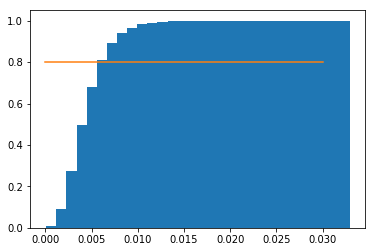

In [8]:
plt.hist(all_out_data[:, :, :, 0].max(axis=-1).max(axis=-1), bins=30, cumulative=True, normed=True)
plt.plot(np.linspace(0, 0.03, 10), np.ones(10) * 0.8)

In [23]:
max_rot = all_out_data[:, :, :, 0].max(axis=-1).max(axis=-1)
rot_labels = np.where(max_rot > 0.008, 1, 0)

In [13]:
train_indices = np.where(all_run_times < pd.Timestamp("2015-01-01"))[0]
test_indices = np.where(all_run_times >= pd.Timestamp("2015-01-01"))[0]

In [11]:
dense_in = Input(shape=all_in_data.shape[1:])
dense = Flatten()(dense_in)
dense = Dense(64)(dense)
dense = Activation("relu")(dense)
dense = Dense(64)(dense)
dense = Activation("relu")(dense)
dense = Dense(1)(dense)
dense = Activation("sigmoid")(dense)
dense_model = Model(dense_in, dense)
opt = Adam(lr=0.0001)
dense_model.compile(opt, "mse")

In [12]:
dense_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 5)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5120)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                327744    
_________________________________________________________________
activation_4 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
activation_5 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
__________

In [14]:
dense_model.fit(norm_in_data[train_indices], rot_labels[train_indices], batch_size=128, epochs=10, verbose=2)

Epoch 1/10
 - 5s - loss: 0.0714
Epoch 2/10
 - 5s - loss: 0.0661
Epoch 3/10
 - 5s - loss: 0.0636
Epoch 4/10
 - 5s - loss: 0.0618
Epoch 5/10
 - 5s - loss: 0.0603
Epoch 6/10
 - 5s - loss: 0.0589
Epoch 7/10
 - 5s - loss: 0.0575
Epoch 8/10
 - 5s - loss: 0.0562
Epoch 9/10
 - 5s - loss: 0.0551
Epoch 10/10
 - 5s - loss: 0.0541


In [40]:
conv_net_in = Input(shape=all_in_data.shape[1:])
conv_net = Conv2D(16, (5, 5), padding="same")(conv_net_in)
conv_net = Activation("elu")(conv_net)
conv_net = AveragePooling2D()(conv_net)
conv_net = Conv2D(32, (5, 5), padding="same")(conv_net)
conv_net = Activation("elu")(conv_net)
conv_net = AveragePooling2D()(conv_net)
conv_net = Conv2D(64, (5, 5), padding="same")(conv_net)
conv_net = Activation("elu")(conv_net)
conv_net = AveragePooling2D()(conv_net)
conv_net = Flatten()(conv_net)
conv_net = Dense(1)(conv_net)
conv_net = Activation("sigmoid")(conv_net)
conv_model = Model(conv_net_in, conv_net)
opt = Adam(lr=0.0001)
conv_model.compile(opt, "mse")

In [41]:
conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 32, 32, 5)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 16)        2016      
_________________________________________________________________
activation_11 (Activation)   (None, 32, 32, 16)        0         
_________________________________________________________________
average_pooling2d_4 (Average (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 32)        12832     
_________________________________________________________________
activation_12 (Activation)   (None, 16, 16, 32)        0         
_________________________________________________________________
average_pooling2d_5 (Average (None, 8, 8, 32)          0         
__________

In [42]:
conv_model.fit(norm_in_data[train_indices], rot_labels[train_indices], batch_size=128, epochs=10, verbose=2)

Epoch 1/10
 - 13s - loss: 0.0781
Epoch 2/10
 - 13s - loss: 0.0665
Epoch 3/10
 - 13s - loss: 0.0639
Epoch 4/10
 - 13s - loss: 0.0628
Epoch 5/10
 - 13s - loss: 0.0620
Epoch 6/10
 - 13s - loss: 0.0613
Epoch 7/10
 - 13s - loss: 0.0608
Epoch 8/10
 - 13s - loss: 0.0602
Epoch 9/10
 - 13s - loss: 0.0597
Epoch 10/10
 - 13s - loss: 0.0593


In [43]:
dense_preds = dense_model.predict(norm_in_data[test_indices])[:, 0]
conv_preds = conv_model.predict(norm_in_data[test_indices])[:, 0]


In [44]:
def brier_score(obs, pred):
    return np.mean((pred - obs) ** 2)

def brier_skill_score(obs, pred):
    return 1 - brier_score(obs, pred) / obs.mean()

conv_bss = brier_skill_score(rot_labels[test_indices], conv_preds)
dense_bss = brier_skill_score(rot_labels[test_indices], dense_preds)

print(conv_bss, dense_bss)

0.341200465998 0.272003220634


In [47]:
out_diff = K.abs(conv_model.output - 1)
grad = K.gradients(out_diff, [conv_model.input])[0]
grad /= K.maximum(K.std(grad), K.epsilon())
iterate = K.function([conv_model.input, K.learning_phase()], 
                         [out_diff, grad])
input_img_data = np.zeros((1, 32, 32, len(in_vars)))
for i in range(100):
    out_loss, out_grad = iterate([input_img_data, 0])
    input_img_data -= out_grad * 0.01

In [45]:
input_img_data[0, :, :, 0].max() * scaling_values.loc[0, "std"] + scaling_values.loc[0, "mean"]

77.200068584073151

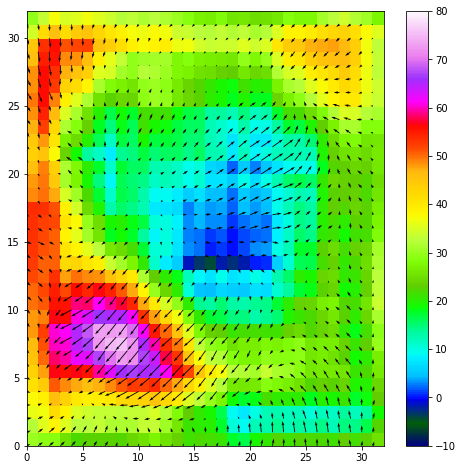

In [55]:
plt.figure(figsize=(8, 8))
plt.pcolormesh(input_img_data[0, :, :, 0] * scaling_values.loc[0, "std"] + scaling_values.loc[0, "mean"], 
               vmin=-10, vmax=80, cmap="gist_ncar")
#plt.contour(gaussian_filter(input_img_data[0, :, :, 3], 1), vmin=-4, vmax=4, cmap="Greens")
plt.colorbar()
plt.quiver(input_img_data[0, :, :, 3], input_img_data[0, :, :, 4])

130982

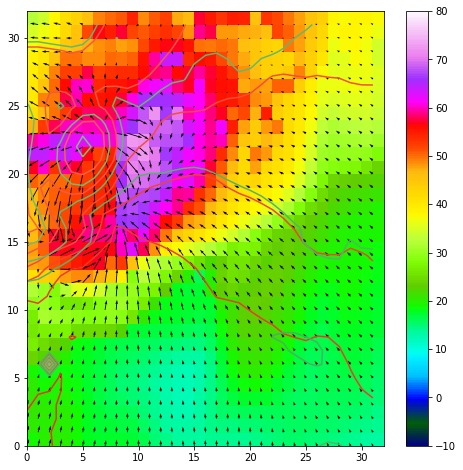

In [57]:
rot_ex = max_rot.argmax()
plt.figure(figsize=(8, 8))
plt.pcolormesh(all_in_data[rot_ex, :, :, 0], cmap="gist_ncar", vmin=-10, vmax=80)
plt.colorbar()
plt.contour(all_in_data[rot_ex, :, :, 1] - 273, np.arange(0, 40, 1), cmap="Reds", vmin=0, vmax=40)
plt.contour(all_in_data[rot_ex, :, :, 2] - 273, np.arange(0, 40, 1), cmap="Greens", vmin=0, vmax=40)

plt.quiver(all_in_data[rot_ex, :, :, 3], all_in_data[130982, :, :, 4])

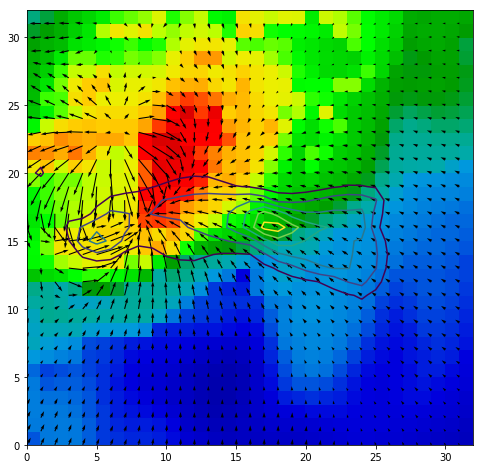

In [149]:
plt.figure(figsize=(8, 8))
plt.pcolormesh(all_in_data[130982, :, :, 0], cmap="nipy_spectral", vmin=0, vmax=80)
#plt.contour(all_in_data[130982, :, :, 1], cmap="Blues")
#plt.contour(all_in_data[130982, :, :, 2] - 273, np.arange(0, 40, 1), cmap="Reds", vmin=0, vmax=40)
#plt.contour(all_in_data[130982, :, :, 3] - 273, np.arange(0, 40, 1), cmap="Greens", vmin=0, vmax=40)
plt.contour(all_out_data[130982, :, :, 0])
plt.quiver(norm_in_data[130982, :, :, 4], norm_in_data[130982, :, :, 5])

In [33]:
scaling_values

,mean,std
0,20.745745,17.947071
1,294.180450,5.841206
2,290.086487,12.729267
3,-0.718525,4.343980
4,1.929636,4.969537
